In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

class GroupMatrixModel(nn.Module):
    def __init__(self, dim=2):
        super(GroupMatrixModel, self).__init__()
        # Инициализируем матрицы A и B как обучаемые параметры
        # Начинаем с случайных матриц
        self.A = nn.Parameter(torch.randn(dim, dim) * 0.1)
        self.B = nn.Parameter(torch.randn(dim, dim) * 0.1)
        self.I = torch.eye(dim)  # Единичная матрица для сравнения
    
    def forward(self):
        # Вычисляем все необходимые произведения матриц
        A2 = torch.mm(self.A, self.A)  # A²
        A3 = torch.mm(A2, self.A)      # A³
        B2 = torch.mm(self.B, self.B)  # B²
        AB = torch.mm(self.A, self.B)  # A·B
        ABA = torch.mm(AB, self.A)     # A·B·A
        
        return A3, B2, ABA
    
    def get_matrices(self):
        return self.A.detach(), self.B.detach()


In [2]:
def train_group_matrices(dim=2, learning_rate=0.01, epochs=1000, print_every=100):
    model = GroupMatrixModel(dim)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    losses = []
    relation_losses = []
    lambda_A3, lambda_B2, lambda_ABA = 1, 1, 1
    beta = 0.9
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Получаем вычисленные матрицы
        A3, B2, ABA = model()
        
        # Вычисляем потери для каждого соотношения (используем Frobenius norm)
        loss_A3 = torch.norm(A3 - model.I, p='fro')  # ||A³ - I||
        loss_B2 = torch.norm(B2 - model.I, p='fro')  # ||B² - I||  
        loss_ABA = torch.norm(ABA - model.B, p='fro')  # ||ABA - B||
        
        # Общая функция потерь
        # total_loss = loss_A3 + loss_B2 + loss_ABA
        # lambda_A3 = beta * max(loss_A3.item(), loss_B2.item(), loss_ABA.item()) / loss_A3.item() + (1 - beta) * lambda_A3
        # lambda_B2 = beta * max(loss_A3.item(), loss_B2.item(), loss_ABA.item()) / loss_B2.item() + (1 - beta) * lambda_B2
        # lambda_ABA = beta * max(loss_A3.item(), loss_B2.item(), loss_ABA.item()) / loss_ABA.item() + (1 - beta) * lambda_ABA
        # lambda_A3, lambda_B2, lambda_ABA = torch.abs(torch.rand((3, 1)) * np.exp(-epoch / 5000))
        total_loss = lambda_A3 * loss_A3 + lambda_B2 * loss_B2 + lambda_ABA * loss_ABA

        # Обратное распространение
        total_loss.backward()
        optimizer.step()
        
        losses.append(total_loss.item())
        relation_losses.append([loss_A3.item(), loss_B2.item(), loss_ABA.item()])
        
        if (epoch + 1) % print_every == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss.item():.6f}')
            print(f'  A³-I: {loss_A3.item():.6f}, B²-I: {loss_B2.item():.6f}, ABA-B: {loss_ABA.item():.6f}')
    
    return model, losses, relation_losses

def verify_relations(A, B):
    """Проверяет, насколько хорошо матрицы удовлетворяют соотношениям группы"""
    I = torch.eye(A.shape[0])
    
    A2 = torch.mm(A, A)
    A3 = torch.mm(A2, A)
    B2 = torch.mm(B, B)
    AB = torch.mm(A, B)
    ABA = torch.mm(AB, A)
    
    print("\n" + "="*50)
    print("ПРОВЕРКА СООТНОШЕНИЙ:")
    print("="*50)
    
    print(f"||A³ - I||: {torch.norm(A3 - I, p='fro'):.8f}")
    print(f"||B² - I||: {torch.norm(B2 - I, p='fro'):.8f}") 
    print(f"||ABA - B||: {torch.norm(ABA - B, p='fro'):.8f}")
    
    print("\nМатрица A:")
    print(A)
    
    print("\nМатрица B:")
    print(B)
    
    print("\nA³ (должна быть близка к I):")
    print(A3)
    
    print("\nB² (должна быть близка к I):")
    print(B2)
    
    print("\nABA (должна быть близка к B):")
    print(ABA)

def plot_training(losses, relation_losses):
    """Визуализация процесса обучения"""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title('Общий лосс')
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    relation_losses = torch.tensor(relation_losses)
    plt.plot(relation_losses[:, 0], label='||A³ - I||')
    plt.plot(relation_losses[:, 1], label='||B² - I||')
    plt.plot(relation_losses[:, 2], label='||ABA - B||')
    plt.title('Лосс по отдельным соотношениям')
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

Обучение матриц, удовлетворяющих соотношениям группы D₃...
Соотношения: A³ = I, B² = I, ABA = B
Epoch [5000/40000], Loss: 2.414263
  A³-I: 1.000040, B²-I: 1.414214, ABA-B: 0.000010
Epoch [10000/40000], Loss: 2.414226
  A³-I: 1.000002, B²-I: 1.414214, ABA-B: 0.000010
Epoch [15000/40000], Loss: 2.414221
  A³-I: 1.000000, B²-I: 1.414214, ABA-B: 0.000008
Epoch [20000/40000], Loss: 1.518892
  A³-I: 0.104678, B²-I: 1.414214, ABA-B: 0.000000
Epoch [25000/40000], Loss: 1.414244
  A³-I: 0.000030, B²-I: 1.414214, ABA-B: 0.000000
Epoch [30000/40000], Loss: 0.394560
  A³-I: 0.000035, B²-I: 0.394506, ABA-B: 0.000020
Epoch [35000/40000], Loss: 0.000075
  A³-I: 0.000033, B²-I: 0.000019, ABA-B: 0.000022
Epoch [40000/40000], Loss: 0.000079
  A³-I: 0.000036, B²-I: 0.000019, ABA-B: 0.000024

ПРОВЕРКА СООТНОШЕНИЙ:
||A³ - I||: 0.00003222
||B² - I||: 0.00001702
||ABA - B||: 0.00002146

Матрица A:
tensor([[1.0000e+00, 3.6275e-06],
        [3.6289e-06, 1.0000e+00]])

Матрица B:
tensor([[ 0.7066,  0.7082],
   

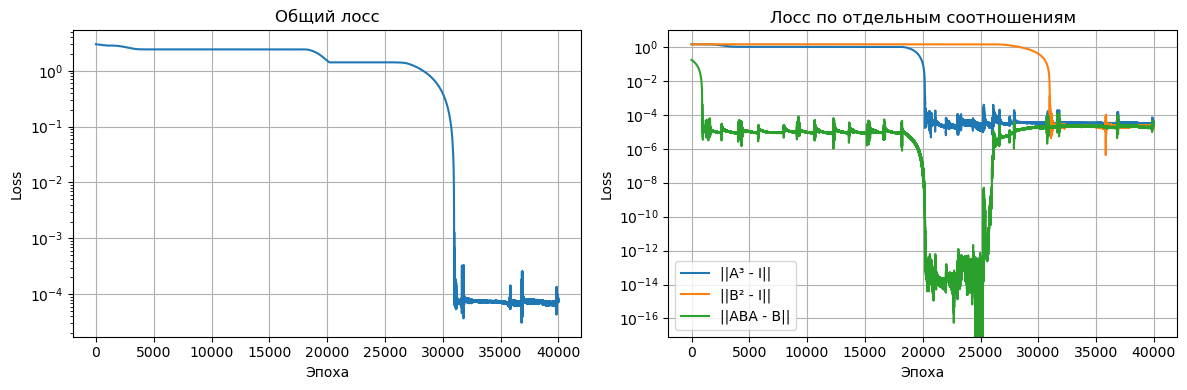


ПРОВЕРКА ЭЛЕМЕНТОВ ГРУППЫ:
e:
tensor([[1., 0.],
        [0., 1.]])
a:
tensor([[1.0000e+00, 3.6275e-06],
        [3.6289e-06, 1.0000e+00]])
a²:
tensor([[1.0000e+00, 7.2550e-06],
        [7.2578e-06, 1.0000e+00]])
b:
tensor([[ 0.7066,  0.7082],
        [ 0.7070, -0.7066]])
ab:
tensor([[ 0.7066,  0.7082],
        [ 0.7070, -0.7066]])
a²b:
tensor([[ 0.7066,  0.7083],
        [ 0.7070, -0.7066]])


In [4]:
# Запуск обучения
print("Обучение матриц, удовлетворяющих соотношениям группы D₃...")
print("Соотношения: A³ = I, B² = I, ABA = B")
print("="*60)
    
    # Обучаем модель
model, losses, relation_losses = train_group_matrices(
    dim=2,
    learning_rate=0.0001,
    epochs=40000,
    print_every=5000
)
    
    # Получаем обученные матрицы
A_trained, B_trained = model.get_matrices()
    
    # Проверяем соотношения
verify_relations(A_trained, B_trained)
    
    # Визуализируем процесс обучения
plot_training(losses, relation_losses)
    
    # Дополнительная проверка: покажем, что группа имеет 6 элементов
print("\n" + "="*50)
print("ПРОВЕРКА ЭЛЕМЕНТОВ ГРУППЫ:")
print("="*50)
    
I = torch.eye(2)
A = A_trained
B = B_trained
A2 = torch.mm(A, A)
    
elements = {
    'e': I,
    'a': A,
    'a²': A2,
    'b': B,
    'ab': torch.mm(A, B),
    'a²b': torch.mm(A2, B)
}
    
for name, elem in elements.items():
    print(f"{name}:\n{elem}", end="\n")